# Clasificación de Hongos — EDA y Modelado

**Dataset:** `mushrooms.csv` (clase: `class` con `e`/`p`).  
**Meta:** EDA completo, ≥5 algoritmos y ≥5 modelos, evaluación con indicadores y cuadro comparativo.  
**Paquete usado:** `PaqEda.py` (`analisisEDA`).

In [1]:
# Imports base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB

# Cargar paquete EDA
import sys
sys.path.append(r"C:\dev\mineria de datos\PaqueteVer1.0")  
from PaqEda import analisisEDA  

# Cargar dataset
df = pd.read_csv(r"C:\dev\mineria de datos\mushrooms.csv")
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [2]:
eda = analisisEDA(r"C:\dev\mineria de datos\mushrooms.csv", 1)
eda.df = df.copy()


# Tipos y nulos
types_info = eda.df.dtypes.astype(str)
missing_per_col = eda.df.isna().sum()

# Duplicados
total_before = eda.df.shape[0]
eda.eliminarDuplicados()
total_after = eda.df.shape[0]

print("Filas antes:", total_before, "| Filas después de eliminar duplicados:", total_after)
print("\nTipos de datos:\n", types_info.value_counts())
print("\nNulos por columna (esperado=0):\n", missing_per_col[missing_per_col>0])

Se eliminaron 0 filas duplicadas. Total actual: 8124 filas.
Filas antes: 8124 | Filas después de eliminar duplicados: 8124

Tipos de datos:
 object    23
Name: count, dtype: int64

Nulos por columna (esperado=0):
 Series([], dtype: int64)


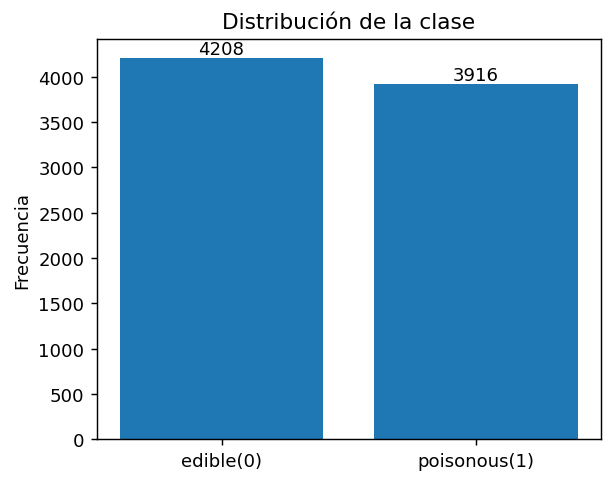

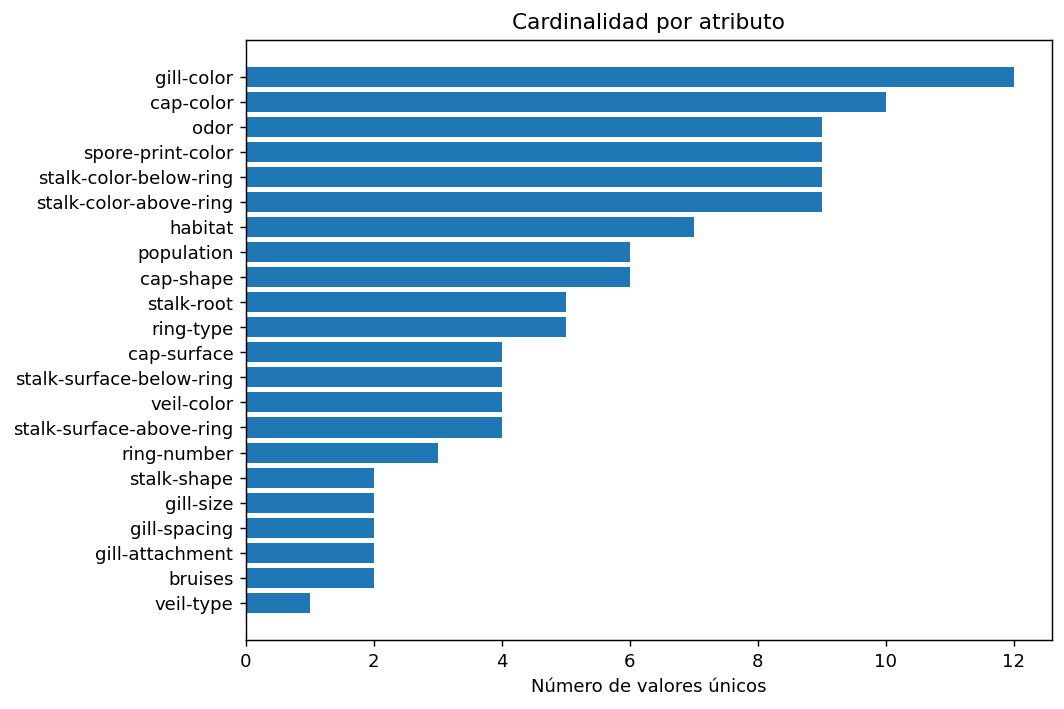

,cardinalidad
gill-color,12
cap-color,10
odor,9
spore-print-color,9
stalk-color-below-ring,9
stalk-color-above-ring,9
habitat,7
population,6
cap-shape,6
stalk-root,5


In [3]:
# Distribución de la clase
class_map = {"e": "edible(0)", "p": "poisonous(1)"}
vc = eda.df["class"].map(class_map).value_counts()

fig = plt.figure(figsize=(5,4), dpi=130)
ax = fig.add_subplot(111)
ax.bar(vc.index, vc.values)
ax.set_title("Distribución de la clase")
ax.set_ylabel("Frecuencia")
for i, v in enumerate(vc.values):
    ax.text(i, v, str(v), ha="center", va="bottom")
plt.show()

# Cardinalidad por atributo
card = eda.df.drop(columns=["class"]).nunique().sort_values(ascending=False)
fig = plt.figure(figsize=(8,6), dpi=130)
ax = fig.add_subplot(111)
ax.barh(card.index, card.values)
ax.invert_yaxis()
ax.set_title("Cardinalidad por atributo")
ax.set_xlabel("Número de valores únicos")
plt.show()

card.to_frame("cardinalidad").head(10)

### Mapa de calor de correlaciones (one-hot)

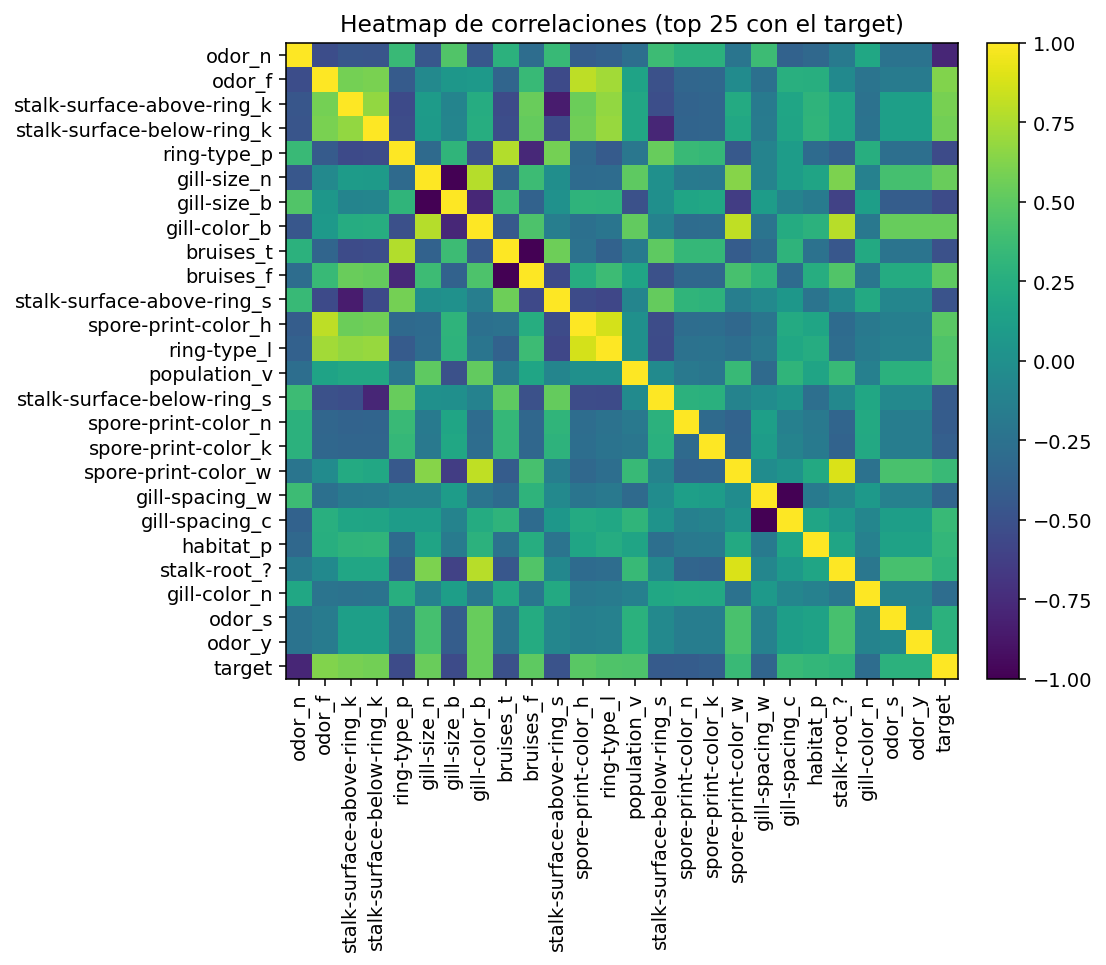

odor_n                        0.785557
odor_f                        0.623842
stalk-surface-above-ring_k    0.587658
stalk-surface-below-ring_k    0.573524
ring-type_p                   0.540469
gill-size_n                   0.540024
gill-size_b                   0.540024
gill-color_b                  0.538808
bruises_t                     0.501530
bruises_f                     0.501530
Name: target, dtype: float64

In [4]:
# One-hot temporal para ver correlaciones (incluye objetivo binario)
df_corr = eda.df.copy()
y_num = df_corr["class"].map({"e":0, "p":1})
X_corr = df_corr.drop(columns=["class"])

ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
Xo = ohe.fit_transform(X_corr)
Xo = pd.DataFrame(Xo, columns=ohe.get_feature_names_out(X_corr.columns), index=X_corr.index)
corr = pd.concat([Xo, y_num.rename("target")], axis=1).corr(numeric_only=True)

# Seleccionamos top 25 correlaciones absolutas con el target para visualizar
c_target = corr["target"].drop("target").abs().sort_values(ascending=False).head(25)
corr_subset = corr.loc[c_target.index.tolist() + ["target"], c_target.index.tolist() + ["target"]]

fig = plt.figure(figsize=(8,7), dpi=140)
ax = fig.add_subplot(111)
im = ax.imshow(corr_subset.values, aspect="auto")
ax.set_xticks(range(corr_subset.shape[1]))
ax.set_yticks(range(corr_subset.shape[0]))
ax.set_xticklabels(corr_subset.columns, rotation=90)
ax.set_yticklabels(corr_subset.index)
ax.set_title("Heatmap de correlaciones (top 25 con el target)")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

c_target.head(10)

In [5]:
# Preparación de datos
y = eda.df["class"].map({"e":0, "p":1})
X = eda.df.drop(columns=["class"])
cat_cols = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

preprocess = ColumnTransformer(
    transformers=[("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)],
    remainder="drop"
)

In [6]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=200),
    "LinearSVC": LinearSVC(),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "BernoulliNB": BernoulliNB()
}

results = []
reports = {}
best = {"name": None, "acc": -1, "cm": None, "pipe": None}

for name, clf in models.items():
    pipe = Pipeline(steps=[("prep", preprocess), ("clf", clf)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    try:
        y_proba = pipe.predict_proba(X_test)[:,1]
    except Exception:
        try:
            y_proba = pipe.decision_function(X_test)
        except Exception:
            y_proba = None

    acc = accuracy_score(y_test, y_pred)
    error = 1 - acc
    auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    reports[name] = rep

    results.append({
        "Modelo": name,
        "Accuracy": acc,
        "Error": error,
        "AUC": auc,
        "Precision_0": rep["0"]["precision"],
        "Recall_0": rep["0"]["recall"],
        "F1_0": rep["0"]["f1-score"],
        "Precision_1": rep["1"]["precision"],
        "Recall_1": rep["1"]["recall"],
        "F1_1": rep["1"]["f1-score"],
        "Support": rep["weighted avg"]["support"],
    })

    if acc > best["acc"]:
        best.update({"name": name, "acc": acc, "cm": confusion_matrix(y_test, y_pred), "pipe": pipe})

import pandas as pd
df_results = pd.DataFrame(results).sort_values(by=["Accuracy","AUC"], ascending=False).reset_index(drop=True)
df_results.round(4)

,Modelo,Accuracy,Error,AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Support
0,LinearSVC,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1625.0
1,KNN,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1625.0
2,DecisionTree,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1625.0
3,RandomForest,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1625.0
4,LogisticRegression,0.9994,0.0006,1.0000,0.9988,1.0000,0.9994,1.0000,0.9987,0.9994,1625.0
5,GradientBoosting,0.9988,0.0012,1.0000,0.9976,1.0000,0.9988,1.0000,0.9974,0.9987,1625.0
6,BernoulliNB,0.9329,0.0671,0.9954,0.8962,0.9846,0.9383,0.9814,0.8774,0.9265,1625.0


C:\Users\jjbs0\AppData\Local\Temp\ipykernel_6316\2500766915.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_results["Modelo"], rotation=45, ha="right")


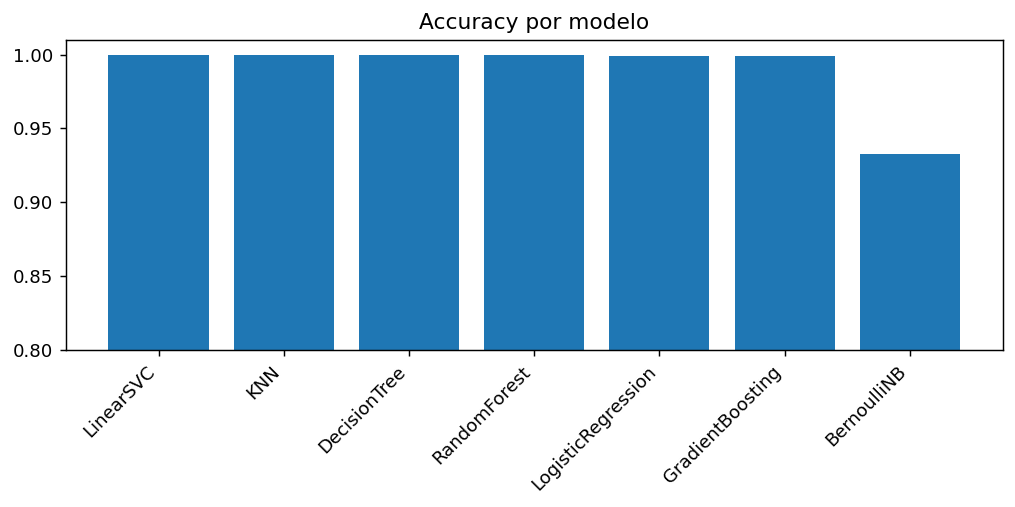

C:\Users\jjbs0\AppData\Local\Temp\ipykernel_6316\2500766915.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(df_results["Modelo"], rotation=45, ha="right")


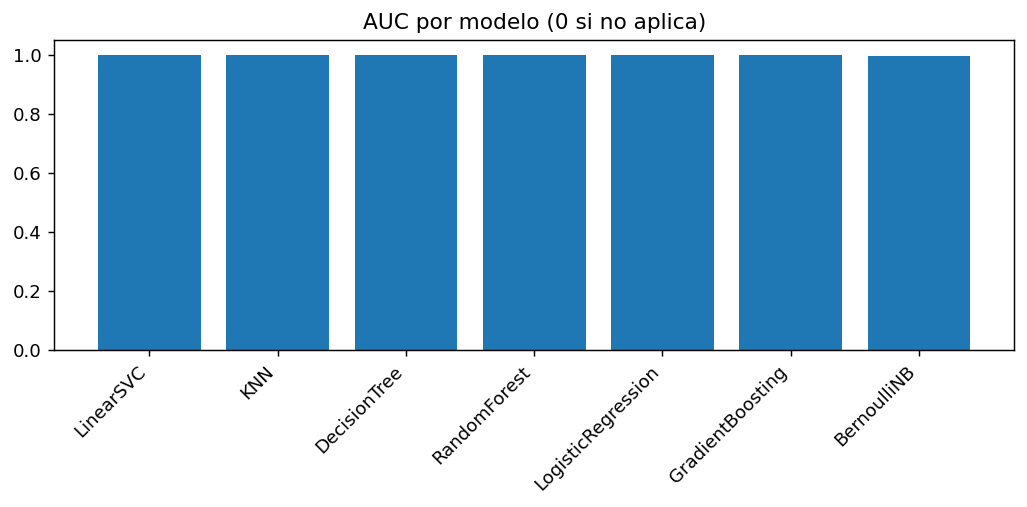

In [7]:
# Barras comparativas de Accuracy y AUC
fig1 = plt.figure(figsize=(8,4), dpi=130)
ax1 = fig1.add_subplot(111)
ax1.bar(df_results["Modelo"], df_results["Accuracy"])
ax1.set_title("Accuracy por modelo")
ax1.set_ylim(0.8, 1.01)
ax1.set_xticklabels(df_results["Modelo"], rotation=45, ha="right")
plt.tight_layout()
plt.show()

fig2 = plt.figure(figsize=(8,4), dpi=130)
ax2 = fig2.add_subplot(111)
ax2.bar(df_results["Modelo"], df_results["AUC"].fillna(0))
ax2.set_title("AUC por modelo (0 si no aplica)")
ax2.set_xticklabels(df_results["Modelo"], rotation=45, ha="right")
plt.tight_layout()
plt.show()

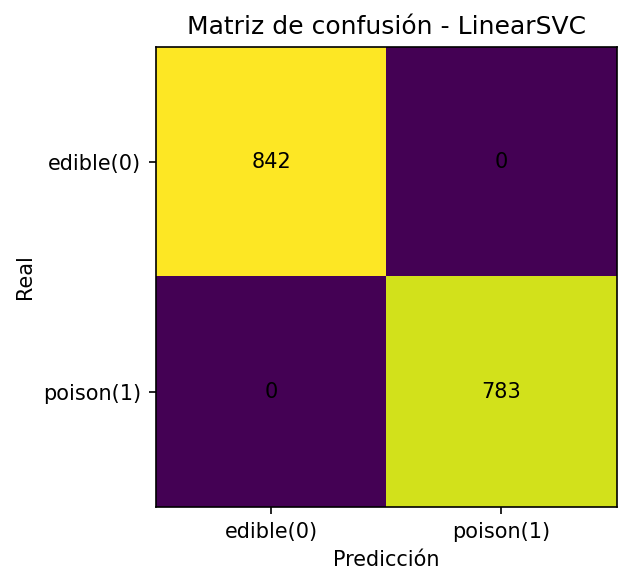

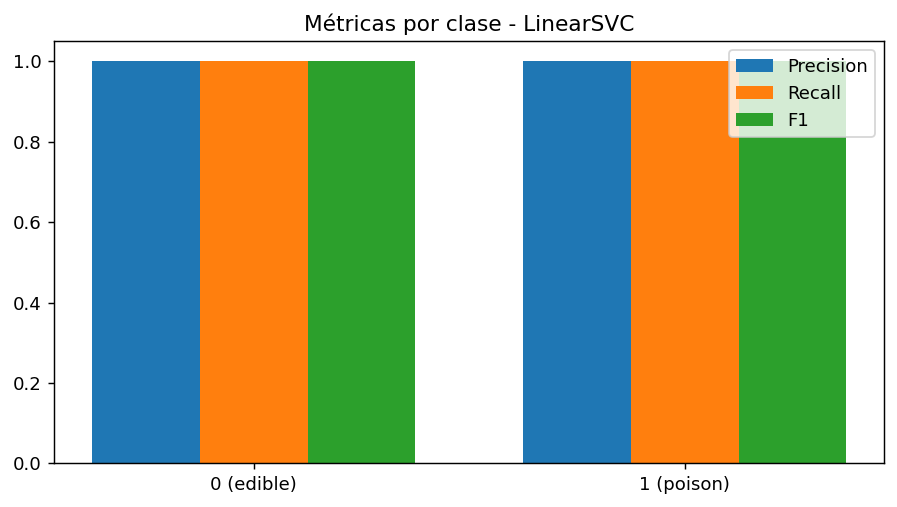

In [8]:
# Matriz de confusión del mejor modelo
cm = best["cm"]
fig = plt.figure(figsize=(5,4), dpi=150)
ax = fig.add_subplot(111)
im = ax.imshow(cm)
ax.set_title(f"Matriz de confusión - {best['name']}")
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["edible(0)","poison(1)"])
ax.set_yticklabels(["edible(0)","poison(1)"])
for (i,j), val in np.ndenumerate(cm):
    ax.text(j, i, int(val), ha="center", va="center")
plt.tight_layout()
plt.show()

# Barras de precision/recall/F1 por clase para el mejor
rep_best = reports[best["name"]]
labels = ["0 (edible)", "1 (poison)"]
prec = [rep_best["0"]["precision"], rep_best["1"]["precision"]]
rec = [rep_best["0"]["recall"], rep_best["1"]["recall"]]
f1  = [rep_best["0"]["f1-score"], rep_best["1"]["f1-score"]]

fig = plt.figure(figsize=(7,4), dpi=130)
ax = fig.add_subplot(111)
x = np.arange(len(labels))
width = 0.25
ax.bar(x - width, prec, width, label="Precision")
ax.bar(x, rec, width, label="Recall")
ax.bar(x + width, f1, width, label="F1")
ax.set_xticks(x); ax.set_xticklabels(labels)
ax.set_title(f"Métricas por clase - {best['name']}")
ax.legend()
plt.tight_layout()
plt.show()

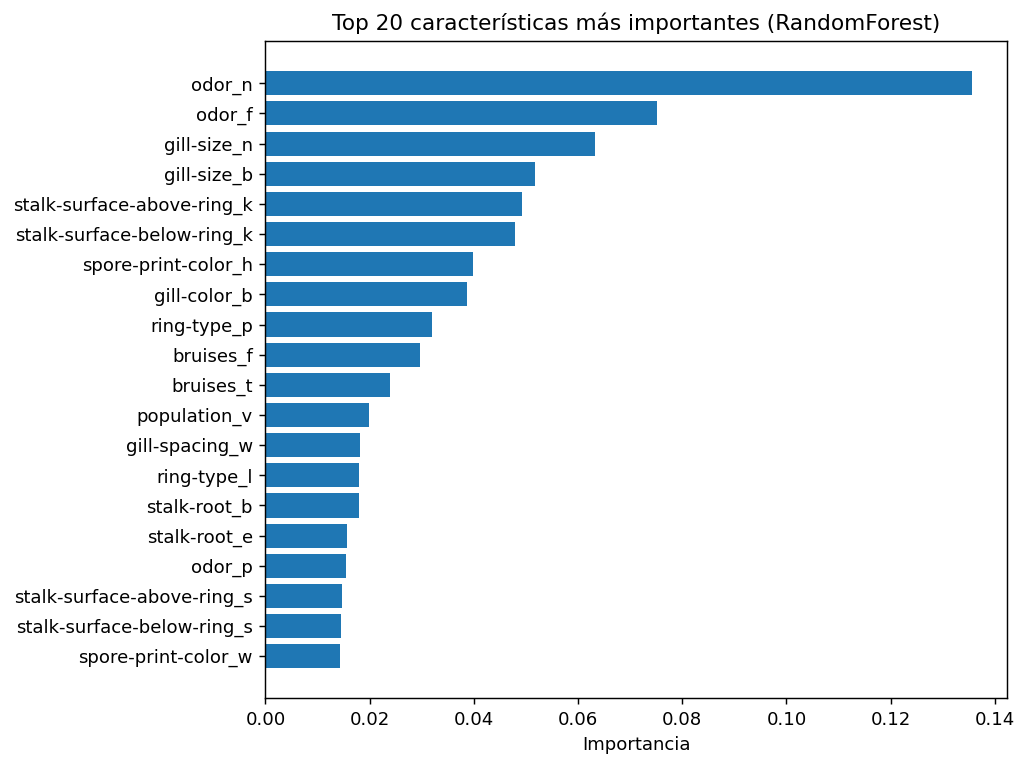

,feature,importance
27,odor_n,0.135529
24,odor_f,0.075194
36,gill-size_n,0.063227
35,gill-size_b,0.051834
57,stalk-surface-above-ring_k,0.049328
61,stalk-surface-below-ring_k,0.047943
96,spore-print-color_h,0.039891
37,gill-color_b,0.038754
94,ring-type_p,0.031980
20,bruises_f,0.029680


In [9]:
# Importancia de variables usando RandomForest 
rf_pipe = Pipeline(steps=[("prep", preprocess),
                         ("clf", RandomForestClassifier(n_estimators=300, random_state=42))])
rf_pipe.fit(X_train, y_train)

# Nombres de columnas después del OneHot
ohe = rf_pipe.named_steps["prep"].named_transformers_["cat"]
feat_names = ohe.get_feature_names_out(cat_cols)
importances = rf_pipe.named_steps["clf"].feature_importances_

imp = (pd.DataFrame({"feature": feat_names, "importance": importances})
         .sort_values("importance", ascending=False)
         .head(20))

fig = plt.figure(figsize=(8,6), dpi=130)
ax = fig.add_subplot(111)
ax.barh(imp["feature"], imp["importance"])
ax.invert_yaxis()
ax.set_title("Top 20 características más importantes (RandomForest)")
ax.set_xlabel("Importancia")
plt.tight_layout()
plt.show()

imp

In [10]:
# Guardar tabla comparativa y reporte rápido
out_csv = r"C:\dev\mineria de datos\model_results.csv"
df_results.to_csv(out_csv, index=False)
print("Resultados guardados en:", out_csv)
df_results.head()

Resultados guardados en: C:\dev\mineria de datos\model_results.csv


,Modelo,Accuracy,Error,AUC,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1,Support
0,LinearSVC,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1625.0
1,KNN,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1625.0
2,DecisionTree,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1625.0
3,RandomForest,1.000000,0.000000,1.0,1.000000,1.0,1.000000,1.0,1.000000,1.000000,1625.0
4,LogisticRegression,0.999385,0.000615,1.0,0.998814,1.0,0.999407,1.0,0.998723,0.999361,1625.0
